ELEC-E8105 

Non-linear filtering and parameter estimation Spring 2019

Erkka Tahvanainen

K80343

Exercise round 6

# Exercise 1. (Optimal Importance Distribution)

Recall the following state space model from Exercise 3 on Round 1:

$ x_k =  \begin{bmatrix} 
 1 & 1 \\
 0 & 1 \end{bmatrix}  x_{k-1} + q_{k-1} = A  x_{k-1} + q_{k-1}$
 

$y_k = \begin{bmatrix}1& 0\end{bmatrix}x_k + v_k =  H x_k + v_k$

where $x_k = (x_k, \dot{x_k})^T$ is state, $y_k$ is measurement and $q_k \sim N(0,\begin{bmatrix}\frac{1}{10^2} & 0 \\
 0 & 1^2 \end{bmatrix})$ and $v_k = N(0,10^2)$ are white gaussian noise processes.

Do the following steps:

**(a)** Write down the Kalman filter equations for this model.



**Prediction step**

$m_k^{-} = A m_{k-1} = \begin{bmatrix} 
 1 & 1 \\
 0 & 1 \end{bmatrix} m_{k-1}  $
 
 $P_k^{-} = A P_{k-1} A^T + Q= \begin{bmatrix} 
 1 & 1 \\
 0 & 1 \end{bmatrix} P_{k-1} \begin{bmatrix} 
 1 & 0 \\
 1 & 1 \end{bmatrix}  + \begin{bmatrix}\frac{1}{10^2} & 0 \\
 0 & 1^2 \end{bmatrix} $


**Update step**


$ S_k =H P_k^{-} H^T + V = \begin{bmatrix}1& 0\end{bmatrix} P_k^{-} \begin{bmatrix}1 \\ 0\end{bmatrix} + 10^2$

$ K_k = P_k^{-}H^T S_k^{-1} = P_k^{-} \begin{bmatrix}1 \\ 0\end{bmatrix} S_k^{-1}$

$m_k = m_k^{-1} + K_k[y_k - H m_k^{-}] = m_k^{-1} + K_k[y_k - \begin{bmatrix}1& 0\end{bmatrix} m_k^{-}]$

$P_k = P_k^{-} - K_k S_k K_k^T$ 

**(b)** Derive expression for the optimal importance distribution for the model:
$$\pi(x_k) = p(x_k|x_{k-1},y_{1:k})$$

$ p(x_k|x_{k-1},y_{1:k}) = p(x_k|x_{k-1},y_{1:k-1},y_k) = p(x_k|x_{k-1},y_k) $ (using Markov property)

$ = \frac{p(y_k|x_k,x_{k-1})p(x_k|x_{k-1})}{p(y_k|x_{k-1})}$ (using Bayes theorem)

$ = \frac{p(y_k|x_k)p(x_k|x_{k-1})}{p(y_k|x_{k-1})}$ (conditional independence)


($ = \frac{p(y_k|x_k)p(x_k|x_{k-1})}{\int_x p(y_k|x_{k}) p(x_k|x_{k-1})dx_k}$ )

$p(x_k|x_{k-1})= N(x_k|A x_{k-1},Q) =N(x_k|\begin{bmatrix} 
 1 & 1 \\
 0 & 1 \end{bmatrix} x_{k-1},\begin{bmatrix}\frac{1}{10^2} & 0 \\
 0 & 1^2 \end{bmatrix}) $

$p(y_k|x_k) = N(x_k| \begin{bmatrix}1& 0\end{bmatrix} x_k,10^2)$

By expressing $y_k$ with terms of $x_{k-1}$ we get

$p(y_k|x_{k-1}) = N(y_k|\begin{bmatrix}1& 1\end{bmatrix}x_{k-1}, \frac{1}{10^2} + 10^2)$

With these it is possible to calculate closed form solution (gaussian), but I ran out of time...

It probably should something like this

$ \pi(x_k)  = N(x_k| Ax_{k-1} + K_k(y_k-HAx_{k-1}), Q - K_k HQ)$

and importance weights are 

$p(y_k|x_{k-1}) = N(y_k| HAx_{k-1}, HQH^T + R) $

**(c)** Write pseudo code for the corresponding particle filter algorithm (sequential
importance resampling algorithm). Also write down the equations for
the weight update.

Initialization
* draw N samples/particles  $x_0^{(i)}$ from prior and set $w_o^{(i)}$ to $\frac{1}{N}$.

Prediction
* Draw N samples $x_k^{(i)}$ from importance distributions

Update
* Calculate weights $w_k^{(i)} \propto w_{k-1}^{(i)} \frac{p(y_k|x_k^{(i)})p(x_k^{(i)}|x_{k-1}^{(i)})}{\pi(x_k)}$

Resampling
* Sample N indexes and pick index i with probability $w_k{(i)} (with replacement)$
* Replace set $x_k^(i)$ with samples picked
* Reset weights to $w_o^{(i)}$ to $\frac{1}{N}$

**(d)** Compare the number of CPU steps (multiplications and additions)
needed by the particle filter and Kalman filter. Which implementation
would you choose for a real implementation?

Particle filter is very CPU intensive (as it needs to run for every particle) and for that reason Kalman filter is probably better choice.

# Exercise 2. (Kalman Filter Based Importance Distribution)

Consider the following non-linear state space model

$$ x_k = x_{k-1} - 0.01 sin (x_{k-1}) + q_{k_1}$$

$$y_k = 0.5 sin (2x_k) + r_k$$

where $q_{k-1}$ has variance $0.01^2$ and $r_k$ has variance $0.02$.

In [1]:
import scipy.io as sio
import math
from filterpy.kalman import ExtendedKalmanFilter
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy.random import normal
import seaborn as sns
%matplotlib notebook

In [2]:
def f(x):
    return x -0.01*math.sin(x)
def h(x):
    return 0.5*math.sin(2*x)
def df(x):
    return 1-0.01*math.cos(x)
def dh(x):
    return math.cos(2*x)

In [3]:
np.random.seed(123)
n = 100
q_sd = 0.01
#I assume here that in exercise there was mistake as sqrt(0.02)=0.14 which is very high...
r_sd = 0.02 #np.sqrt(0.02)
x_meas = np.zeros(n)
y_meas = np.zeros(n)
x_true = np.zeros(n)
y_true = np.zeros(n)
x_true[0] = 0
y_true[0] = h(x_true[0])
for j in range(1,n):
    x_meas[j] = f(x_true[j-1]) + normal(0,q_sd)
    y_true[j] = h(x_meas[j])
    #I assume here that 
    y_meas[j] = y_true[j] + normal(0,r_sd)

## EKF

In [4]:
est_y = np.zeros(n)
mk = np.array([f(0)])
Pk = np.array([0.01**2])
for k in range(n):
    #Prediction
    mk_ =  np.array([[f(mk)]])
    F = np.array([[df(mk)]])
    Pk_ = F @ np.array([Pk])@ F.T + q_sd**2
    #Update
    v_k = np.array([[y_meas[k] - h(mk_)]])
    H = np.array([[dh(mk_)]])
    S_k = H@Pk_@H.T + r_sd**2
    K_k = Pk_@H.T @ np.linalg.inv(S_k)
    mk = (mk_ + K_k @ v_k).flatten()
    Pk = (Pk_ - K_k @S_k@K_k).flatten()

    est_y[k] = mk

## Bootstrap filter

In bootstrap filter we draw samples from dynamic model

$$ p(x_k |x_{k-1}) = N(x_k| x_{k-1} - 0.01 sin (x_{k-1}),0.01^2)$$

For weights
$$ p(y_k|x_k) = N(y_k| 0.5 sin (2x_k) , 0.02)$$

In [5]:
from scipy.stats import norm

In [6]:
n = 10000
T = len(y_meas)
#lenght of obs x number of particles
x = np.zeros(shape=(T, n))

In [7]:
vect_f = np.vectorize(f)
vect_h = np.vectorize(h)

In [8]:
#Initialize x[0] 
x[0] = norm.rvs(loc=vect_f(x[0]),scale = q_sd, size = n)
est_2 = np.zeros(T)
#indexes to array
indexes = np.array(range(0,n))
#calculate weights
w_ki = norm.pdf(y_meas[0],loc = vect_h(x[0]), scale=r_sd)
w_ki = w_ki/np.sum(w_ki)
#resampling
selected_indexes = np.random.choice(indexes,p=w_ki,size=n)
x = x[:,selected_indexes]

for t in range(1,T):
    #draw samples from dynamic model
    x[t] = norm.rvs(loc=vect_f(x[t-1]),scale = q_sd, size = n)
  
    #calculate weights 
    w_ki = norm.pdf(y_meas[t],loc = vect_h(x[t]), scale=r_sd)
    w_ki = w_ki/np.sum(w_ki)
    #resampling
    est_2[t] = np.sum( w_ki * x[t])
    selected_indexes = np.random.choice(indexes,p=w_ki,size=n)
    
    x = x[:,selected_indexes]




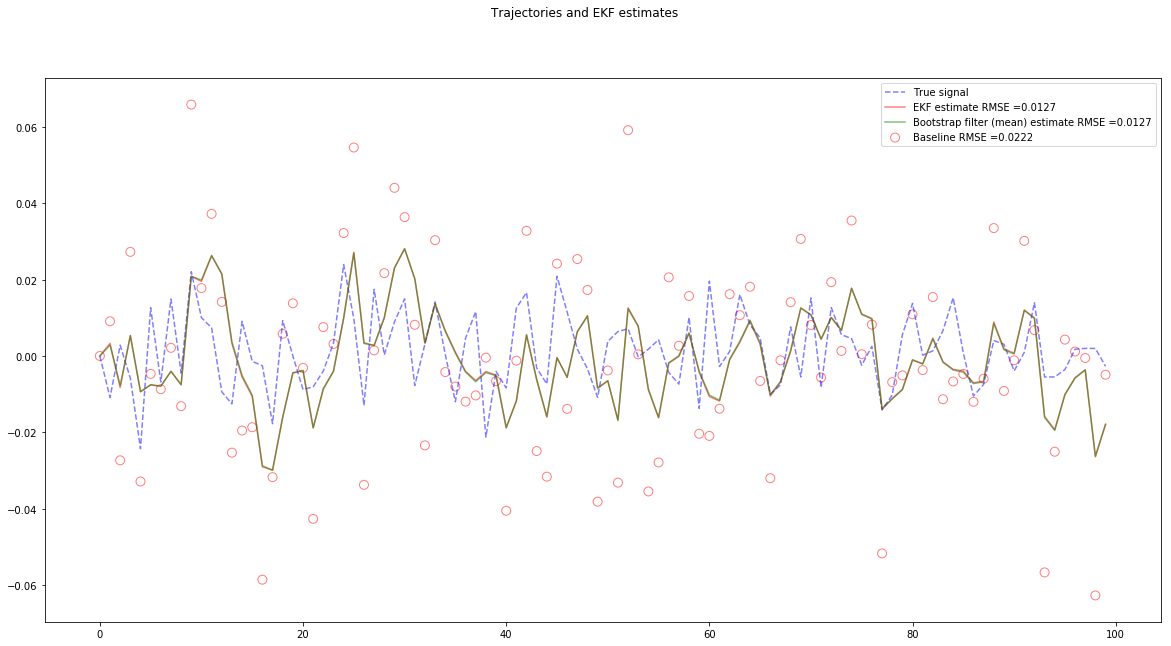

In [10]:
t = range(len(y_meas))
plt.figure(figsize=(20,10))
plt.suptitle("Trajectories and EKF estimates")
plt.plot(t,y_true,label = "True signal",linestyle='--',color='b',alpha=0.5)
plt.scatter(t,y_meas, 
                 label = "Baseline RMSE ={:0.4f}".format(np.sqrt(mean_squared_error(y_true,y_meas))),
                   s=80, facecolors='none', edgecolors='r',alpha=0.5)
plt.plot(t,est_y, 
                 label = "EKF estimate RMSE ={:0.4f}".format(np.sqrt(mean_squared_error(y_true,est_y)))
                ,linestyle='-',color='r',alpha=0.5)
plt.plot(t,est_2, 
                 label = "Bootstrap filter (mean) estimate RMSE ={:0.4f}".format(np.sqrt(mean_squared_error(y_true,est_2)))
                ,linestyle='-',color='g',alpha=0.5)
plt.legend()
plt.show()

# Exercise 3. (Bearings Only Tracking with SIR)

where $q_k$ is a zero mean Gaussian process noise with covariance

$$Q = \begin{pmatrix} 
 q_1^c \Delta t^3/3 & 0 & q_1^c\Delta t^2/2 & 0 \\
 0 & q_2^c \Delta t^3/3 & 0 & q_2^c \Delta t^2 /2\\
 q_1^c \Delta t^2/2 & 0 & q_1^c \Delta t & 0 \\
 0 & q_2^c \Delta t^2/2 & 0 & q_2^c \Delta t 
  \end{pmatrix}$$
  
  
In this scenario the diffusion coefficients are $q_c^1 = q_c^2 = 0.1$ and the sampling period is $\Delta t = 0.1$. The measurement model for sensor $i \in \{1, 2\}$ is the following:

$$\theta_k^i = tan^{-1} \big(\frac{y_k - s_y^i}{x_k - s_x^i}\big) +r_k$$

where $(s_x^i,s_y^i)$ is the position of the sensor $i$ and $r_k \sim N(0, \sigma^2)$ is a Gaussian
measurement noise with standard deviation of $\sigma = 0.05$ radians. At each sampling time, which occurs 10 times per second (i.e., $\Delta t = 0.1$), both of the two sensors produce a measurement.

In the file angle_ex.m (in MyCourses) there is a baseline solution, which
computes estimates of the position from the crossing of the measurements
and estimates the velocity to be always zero. Your task is to implement an
EKF for the problem and compare the results graphically and in RMSE
sense.

In [11]:
from scipy.linalg import cholesky

In [12]:
#load simulated data.
Theta = sio.loadmat('Theta.mat')['Theta']
Theta = Theta.swapaxes(0,1)
X = sio.loadmat('X.mat')['X']
X = X.swapaxes(0,1)

In [13]:
steps = Theta.shape[0]
x0 = np.array([[0],[0],[1],[0]])
S1 = np.array([[-1.5],[0.5]])# Position of sensor 1
S2 = np.array([[1],[1]])      # Position of sensor 2


In [14]:
qc = 0.1
dt = 0.01
sd = 0.05;
#This is the transition matrix
A = np.array([[1,0,dt,0],
             [0,1,0,dt],
             [0,0,1,0],
             [0,0,0,1]])
#This is the process noise covariance
Q = np.array([[qc*dt**3/3,0, qc*dt**2/2, 0],
       [0, qc*dt**3/3, 0, qc*dt**2/2],
       [qc*dt**2/2, 0, qc*dt, 0],
       [0, qc*dt**2/2, 0, qc*dt]])

In [15]:
# Initialize to true value
m1 = x0
EST1 = np.zeros((steps,4))
  

# Loop through steps
for k in range(steps):
    # Compute crossing of the measurements
    dx1 = np.cos(Theta[k,0])
    dy1 = np.sin(Theta[k,0])
    dx2 = np.cos(Theta[k,1])
    dy2 = np.sin(Theta[k,1])
    d = np.linalg.solve(np.array([[dx1, dx2],[dy1, dy2]]),np.array([S2[0]-S1[0],S2[1]-S1[1]]))
    # Crossing
    cross_xy = S1 + np.array([[dx1],[dy1]])*d[0]
    # compute estimate
    m1 = np.concatenate([cross_xy.flatten(),[0],[0]])
    EST1[k,:] = m1  

In [16]:
def rmse(X1,X2):
    return np.sqrt(np.mean(np.sum((X1-X2)**2,axis=1)))

# Baseline solution

Animation

In [17]:
from matplotlib import animation, rc

In [18]:
def animate_estimate(EST,title_sol):
    rc('animation', embed_limit=41030228 )
    fig1,ax = plt.subplots(figsize=(20,10))
    ax.set_title('{} solution'.format(title_sol))
    ax.set_xlim([-2,2])
    ax.set_ylim([-2.5,1.5])
    ax.plot(X[:,0],X[:,1],linestyle = '--',color='b',alpha=0.5,label='True trajectory')
    ax.scatter(S1[0],S1[1],marker = 'X',s=80, facecolors='none', edgecolors='k',label='Sensor 1')
    ax.scatter(S2[0],S2[1],s=80, facecolors='none', edgecolors='k',label='Sensor 2')
    l, = ax.plot([],[],linestyle = '-',color='r',alpha=0.5,label='{} estimate RMSE = {:0.3f}'.format(title_sol,rmse(X,EST)))
    o, = ax.plot([],[],marker = 'o', color='k')
    s_1, = ax.plot([],[],linestyle = '--',color='k')
    s_2, = ax.plot([],[],linestyle = '--',color='k')
    ax.legend()

    def animate(i):
        l.set_data(EST[:i+1,0],EST[:i+1,1])
        o.set_data(EST[i:i+1,0],EST[i:i+1,1])
        len = 4 
        dx1 = len*np.cos(Theta[i,0]);
        dy1 = len*np.sin(Theta[i,0]);
        dx2 = len*np.cos(Theta[i,1]);
        dy2 = len*np.sin(Theta[i,1]);
        s_1.set_data([S1[0],S1[0]+dx1],[S1[1],S1[1]+dy1])
        s_2.set_data([S2[0],S2[0]+dx2],[S2[1],S2[1]+dy2])
        return (l,o,s_1,s_2)
    def init():
        l.set_data([],[])
        o.set_data([],[])
        s_1.set_data([],[])
        s_2.set_data([],[])
        return (l,o,s_1,s_2)

    return animation.FuncAnimation(fig1, animate, init_func=init,frames=len(EST))

In [19]:
def plot_estimate(EST,title_sol):
    plt.figure(figsize=(20,10))
    plt.title('{} solution'.format(title_sol))
    plt.xlim([-2,2])
    plt.ylim([-2.5,1.5])
    plt.plot(X[:,0],X[:,1],linestyle = '--',color='b',alpha=0.5,label='True trajectory')
    plt.plot(EST[:,0],EST[:,1],linestyle = '-',color='r',alpha=0.5,label='{} estimate RMSE = {:0.3f}'.format(title_sol,rmse(X,EST)))
    plt.scatter(S1[0],S1[1],marker = 'X',s=80, facecolors='none', edgecolors='k',label='Sensor 1')
    plt.scatter(S2[0],S2[1],s=80, facecolors='none', edgecolors='k',label='Sensor 2')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

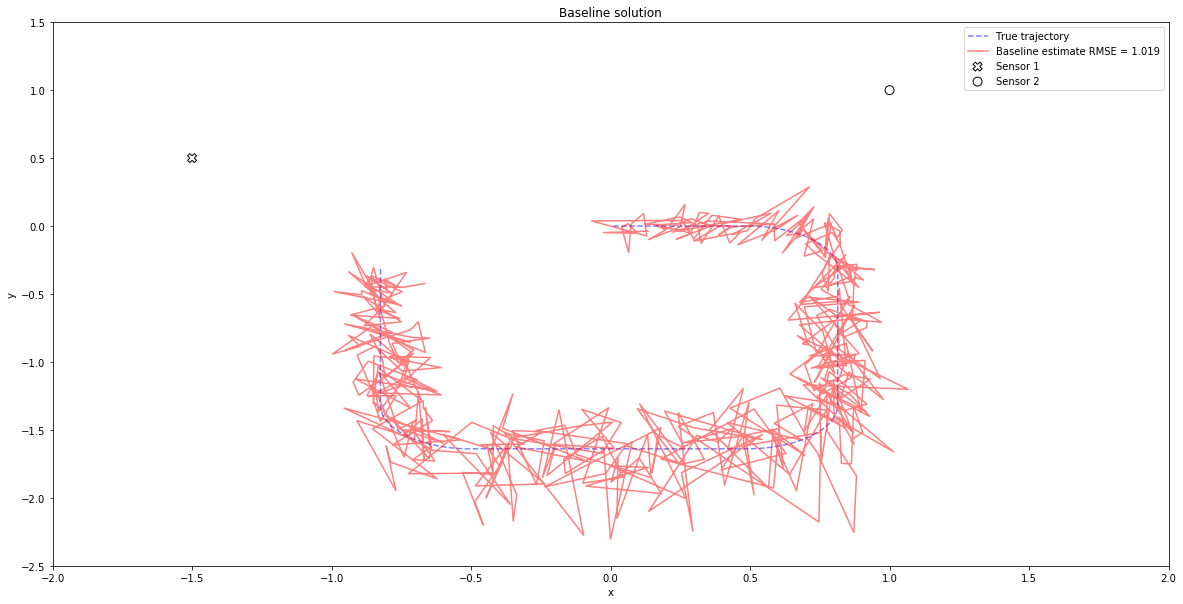

In [20]:
plot_estimate(EST1,"Baseline")

# EKF



 $$\frac{d arctan(x)}{dx} = \frac{1}{1+x^2}$$
 
 $$ \frac{f(g(x))}{dx} = \frac{df(g(x))}{dx}\frac{g(x)}{dx}$$

In [21]:
def darctan(x):
    return 1.0/(1+x**2)

def g(mk,s):
    return (mk[1,0]-s[1,0])/(mk[0,0]-s[0,0])

def derivative_x(mk,s):
    return (s[1,0]-mk[1,0])/(s[0,0]**2 - 2*s[0,0]*mk[0,0]+s[1,0]**2 - 2 *s[1,0]*mk[1,0] + mk[0,0]**2 + mk[1,0]**2)

def derivative_y(mk,s):
    return (mk[0,0]-s[0,0])/(s[0,0]**2 - 2.0*s[0,0]*mk[0,0]+s[1,0]**2 - 2 *s[1,0]*mk[1,0] + mk[0,0]**2 + mk[1,0]**2)
    
def dgy(mk,s):
    return 1.0/(mk[0,0]-s[0,0])
def dgx(mk,s):
    return -(mk[1,0]-s[1,0])/(mk[0,0]-s[0,0])**2
def h(mk,s):
    return np.arctan2(mk[1,0]-s[1,0],mk[0,0]-s[0,0])

In [22]:
m2 = x0           # Initialize to true value
P2 = np.eye(4)        # Some uncertainty
R  = sd**2*np.eye(2)   # The joint covariance
EST2 = np.zeros((steps,4))

for k in range(steps):
    #predict
    mk_ = A @ m2
    Pk_ = A @ P2 @A.T + Q
    #update
    v_k = (Theta[k] - np.array([[h(mk_,S1),h(mk_,S2)]])).T
    #H  = np.array([[darctan(g(mk_,S1))*dgx(mk_,S1),darctan(g(mk_,S1))*dgy(mk_,S1),0,0],
    #               [darctan(g(mk_,S2))*dgx(mk_,S2),darctan(g(mk_,S2))*dgy(mk_,S2),0,0]])
    H = np.array([[derivative_x(mk_,S1), derivative_y(mk_,S1),0,0],
                 [derivative_x(mk_,S2),derivative_y(mk_,S2),0,0]])
    S_k = H@Pk_@H.T + R
    K_k = Pk_@H.T @ np.linalg.inv(S_k)
    m2 = mk_ + K_k @ v_k
    P2 = Pk_ - K_k @ S_k @ K_k.T
    EST2[k,:] = m2.flatten()

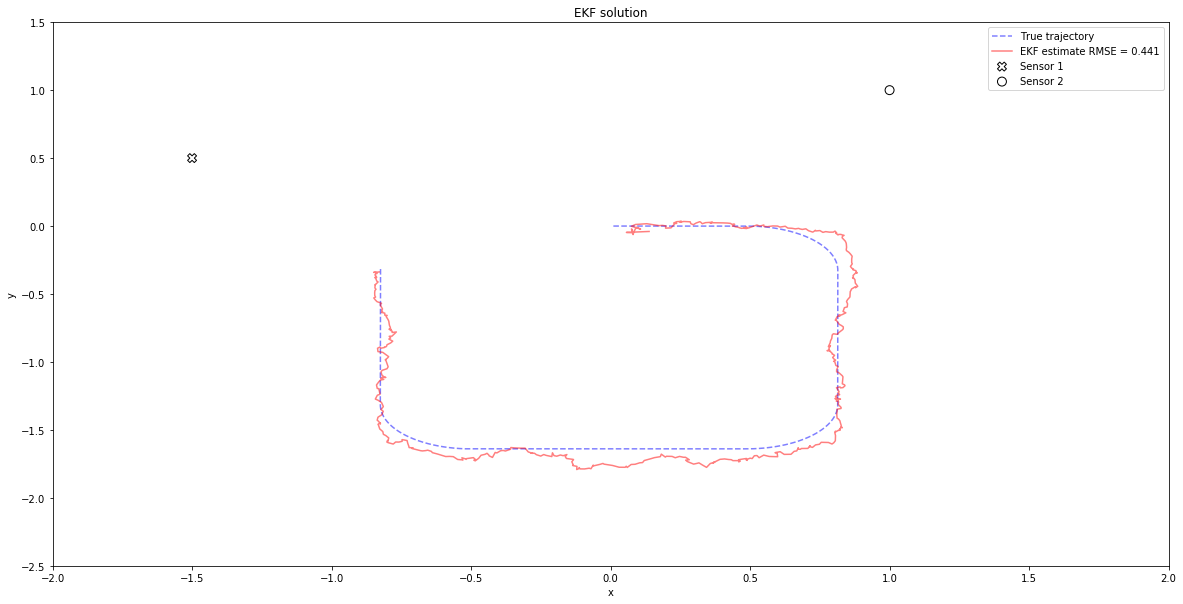

In [23]:
plot_estimate(EST2,"EKF")

## Unscented Kalman filter

In [24]:
# Precompute the UT weights
n = 4;
alpha = 1;
beta = 0;
#   kappa = 3-n;
kappa = 0;

lambda_ = alpha**2 * (n + kappa) - n;        
WM = np.zeros(2*n+1);
WC = np.zeros(2*n+1);
for j in range(0,2*n+1):
    if j==0:
        wm = lambda_ / (n + lambda_);
        wc = lambda_ / (n + lambda_) + (1 - alpha**2 + beta);
    else:
        wm = 1 / (2 * (n + lambda_));
        wc = wm;
    
    WM[j] = wm;
    WC[j] = wc;

In [25]:
def hx(x):
# measurement function - convert state into a measurement
# where measurements are [x_pos, y_pos]
    return np.array([[h(x,S1)],[h(x,S2)]])

In [26]:
m = x0          # Initialize to true value
dim_x = 4
dim_y = 2
P = np.eye(dim_x)        # Some uncertainty
Ms = []
Ps = []
multipliers = [np.sqrt(n+lambda_) for i in range(0,n)]+[-np.sqrt(n+lambda_) for i in range(0,n)]
for inx,val in enumerate(Theta):
    #print("loop")
    P_SQRT = cholesky(P,lower=True)
    sigma_points = np.zeros((len(WM),dim_x,1))
    sigma_y = np.zeros((len(WM),dim_y,1))
    sigma_f = np.zeros((len(WM),dim_x,1))
    #calculate sigma points around m with f
    sigma_points[0] = m
    sigma_f[0] = np.dot(A,sigma_points[0])
    for i in range(1,len(sigma_points)):
        sigma_points[i] = m + multipliers[i-1]*P_SQRT[:,(i-1)%dim_x].reshape(dim_x,1)
        sigma_f[i] = np.dot(A,sigma_points[i])
   
    mk_ = np.zeros((dim_x,1))
    Pk_ = np.zeros((dim_x,dim_x)) 

    #prediction step
    mk_ = sigma_f.squeeze().T.dot(WM).reshape((dim_x,1))
    points_diff_f = sigma_f.squeeze().T - mk_
    Pk_ = points_diff_f.dot(np.diag(WC)).dot(points_diff_f.T) + Q
   
    #print(sigma_points.reshape(4,9)@WM)
   
    #update step

    P_SQRT = cholesky(Pk_,lower=True)
   
    #calculate sigma points around mk_ with h
    sigma_points[0] = mk_
    sigma_y[0] = hx(sigma_points[0])
    
    for i in range(1,len(sigma_points)):
            sigma_points[i] = mk_ + multipliers[i-1]*P_SQRT[:,(i-1)%dim_x].reshape(dim_x,1) 
            sigma_y[i] = hx(sigma_points[i])
            
    mu_k = np.zeros((dim_y,1))
    S_k = np.zeros((dim_y,dim_y))
    C_k  = np.zeros((dim_x,dim_y))
    
    mu_k = sigma_y.squeeze().T.dot(WM).reshape((dim_y,1))
    points_diff_y = sigma_y.squeeze().T - mu_k
    S_k = points_diff_y.dot(np.diag(WC)).dot(points_diff_y.T) + R
    C_k = points_diff_f.dot(np.diag(WC)).dot(points_diff_y.T)
    
    K_k = C_k@np.linalg.inv(S_k)
    m = mk_ + K_k@(val.reshape(dim_y,1) - mu_k)
    P = Pk_ - K_k@S_k@K_k.T
    
    Ms.append(m)
    Ps.append(P)
EST_UKF = np.array(Ms).squeeze()

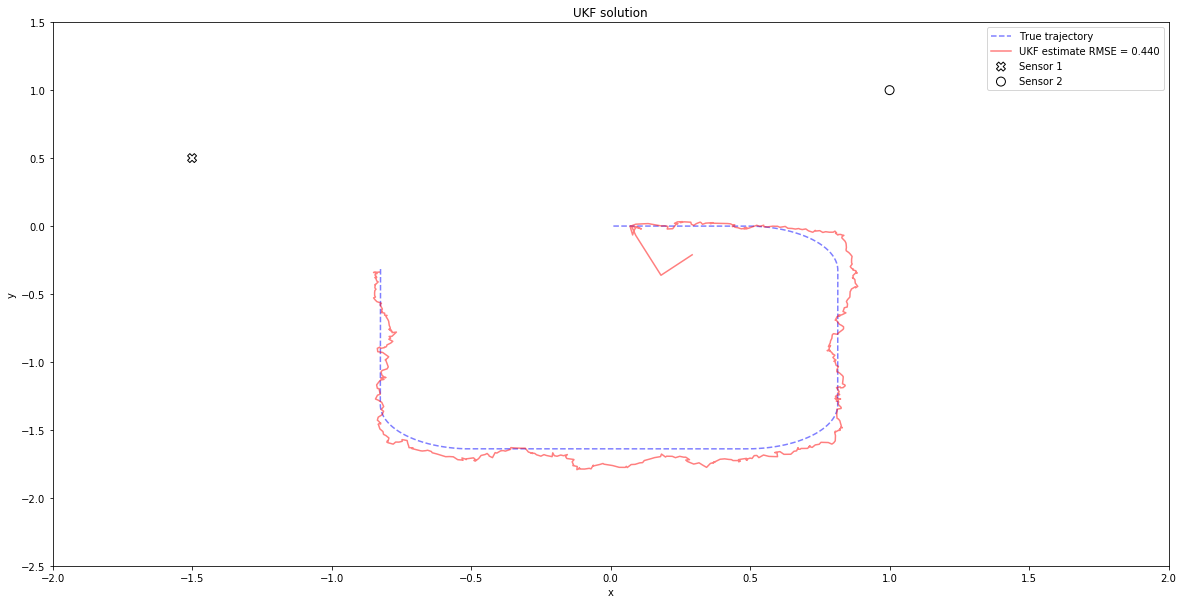

In [27]:
plot_estimate(EST_UKF,"UKF")

# Cubature Kalman Filter

In [28]:
n = 4
multipliers = [np.sqrt(n) for i in range(0,n)]+[-np.sqrt(n) for i in range(0,n)]
unit_vectors = np.array([[[1],[0],[0],[0]],[[0],[1],[0],[0]],[[0],[0],[1],[0]],[[0],[0],[0],[1]]])


In [29]:
m = x0          # Initialize to true value
dim_x = 4
dim_y = 2
P = np.eye(dim_x)        # Some uncertainty
Ms = []
Ps = []
n = 4
multipliers = [np.sqrt(n) for i in range(0,n)]+[-np.sqrt(n) for i in range(0,n)]
unit_vectors = np.array([[[1],[0],[0],[0]],[[0],[1],[0],[0]],[[0],[0],[1],[0]],[[0],[0],[0],[1]]])
for inx,val in enumerate(Theta):
    P_SQRT = cholesky(P,lower=True)
    sigma_points = np.zeros((len(multipliers),dim_x,1))
    sigma_y = np.zeros((len(multipliers),dim_y,1))
    sigma_f = np.zeros((len(multipliers),dim_x,1))
    #calculate sigma points around m with f
    for i in range(0,len(sigma_points)):
        sigma_points[i] = m + multipliers[i]*P_SQRT@unit_vectors[i%n]
        sigma_f[i] = np.dot(A,sigma_points[i])
      #prediction step
    mk_ = np.sum(sigma_f,axis=0)/(2*n)

    
    points_diff_f = (sigma_f-mk_).squeeze().T
    Pk_ = points_diff_f.dot(points_diff_f.T)/(2*n) + Q
    #update step
    
    P_SQRT = cholesky(Pk_,lower=True)
   
    #calculate sigma points around mk_ with h
    
    for i in range(0,len(sigma_points)):
        sigma_points[i] = mk_ + multipliers[i]*P_SQRT@unit_vectors[i%n]
        sigma_y[i] =  hx(sigma_points[i])
        
            
    mu_k =  np.sum(sigma_y,axis=0)/(2*n)

    points_diff_y = (sigma_y-mu_k).squeeze().T
    S_k = points_diff_y.dot(points_diff_y.T)/(2*n) + R
    C_k = points_diff_f.dot(np.diag(np.repeat(1/(2.0*n),len(sigma_points)))).dot(points_diff_y.T)
  
    
    K_k = C_k@np.linalg.inv(S_k)
    m = mk_ + K_k@(val.reshape(dim_y,1) - mu_k)
    P = Pk_ - K_k@S_k@K_k.T

    Ms.append(m)
    Ps.append(P)
EST_CKF = np.array(Ms).squeeze()

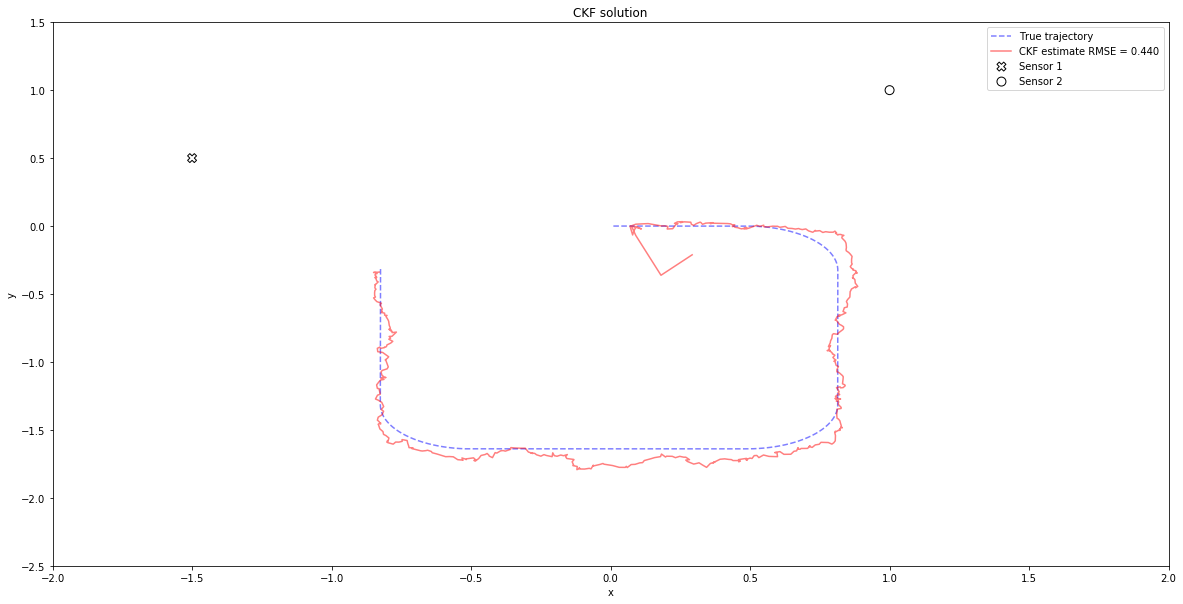

In [30]:
plot_estimate(EST_CKF,"CKF")

# Bootstrap filter

In [31]:
from scipy.stats import multivariate_normal

In [32]:
n = 10000
T = len(Theta)
#lenght of obs x number of particles
x = np.zeros(shape=(T, n, 4))

In [33]:
def angle(x_k,s):
    return np.arctan2(x_k[:,1]-s[1,0],x_k[:,0]-s[0,0])

In [34]:
#Initialize x[0] with true value
x[0] = np.repeat(x0,n,axis=1).T
est = np.zeros(shape=(T,4))
#indexes to array
indexes = np.array(range(0,n))
#calculate weights
w_ki = [ multivariate_normal.pdf(Theta[0],mean,cov=np.eye(2)*0.05) for mean in np.array([angle(x[0],S1),angle(x[0],S2)]).T]
w_ki = w_ki/np.sum(w_ki)
#resampling
selected_indexes = np.random.choice(indexes,p=w_ki,size=n)
est[0] = np.sum(w_ki.reshape(-1,1)*x[0,selected_indexes],axis=0)
x = x[:,selected_indexes]
for t in range(1,T):
    #draw samples from dynamic model
   
    x[t] = [multivariate_normal.rvs(mean=(A@x_t),cov = Q) for x_t in x[t-1]]
     #calculate weights 
    w_ki =  [ multivariate_normal.pdf(Theta[t],mean,cov=np.eye(2)*0.05) for mean in np.array([angle(x[t],S1),angle(x[t],S2)]).T]
    w_ki = w_ki/np.sum(w_ki)
    
    est[t] = np.sum(w_ki.reshape(-1,1)*x[t],axis=0)
    #resampling
    selected_indexes = np.random.choice(indexes,p=w_ki,size=n)
    
    x = x[:,selected_indexes]

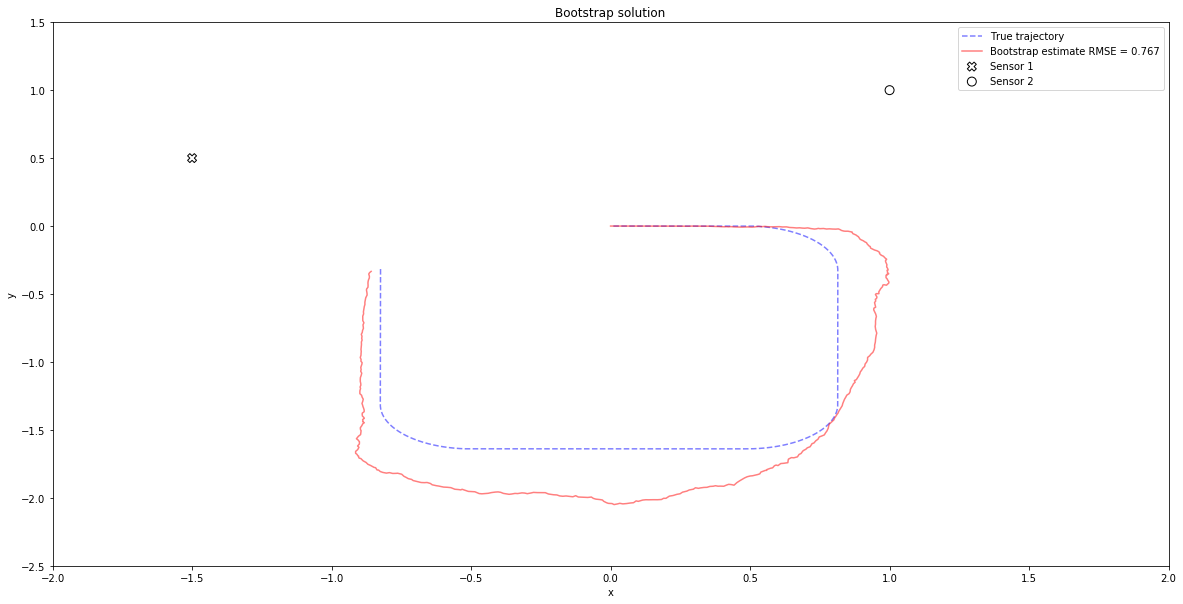

In [35]:
plot_estimate(est,"Bootstrap")

Result improves with number of particles but seem to be very slow progress...